In [1]:
!pip install lightning
!apt-get install -y libgeos-dev
!pip install basemap basemap-data-hires


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 40.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.12.1-1~jammy0).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 398.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import torch.utils.data
import math


class LayerNorm(nn.Module):
    """
    layer normalization
    Simple layer norm object optionally used with the convolutional encoder.
    """

    def __init__(self, feature_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones((feature_dim,)))
        self.register_parameter("gamma", self.gamma)
        self.beta = nn.Parameter(torch.zeros((feature_dim,)))
        self.register_parameter("beta", self.beta)
        self.eps = eps

    def forward(self, x):
        # x: [batch_size, embed_dim]
        # normalize for each embedding
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # output shape is the same as x
        # Type not match for self.gamma and self.beta??????????????????????
        # output: [batch_size, embed_dim]
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def get_activation_function(activation, context_str):
    if activation == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "sigmoid":
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        raise Exception("{} activation not recognized.".format(context_str))


class SingleFeedForwardNN(nn.Module):
    """
        Creates a single layer fully connected feed forward neural network.
        this will use non-linearity, layer normalization, dropout
        this is for the hidden layer, not the last layer of the feed forard NN
    """

    def __init__(self, input_dim,
                 output_dim,
                 dropout_rate=None,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=''):
        '''

        Args:
            input_dim (int32): the input embedding dim
            output_dim (int32): dimension of the output of the network.
            dropout_rate (scalar tensor or float): Dropout keep prob.
            activation (string): tanh or relu or leakyrelu or sigmoid
            use_layernormalize (bool): do layer normalization or not
            skip_connection (bool): do skip connection or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(SingleFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if dropout_rate is not None:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

        self.act = get_activation_function(activation, context_str)

        if use_layernormalize:
            # the layer normalization is only used in the hidden layer, not the last layer
            self.layernorm = nn.LayerNorm(self.output_dim)
        else:
            self.layernorm = None

        # the skip connection is only possible, if the input and out dimention is the same
        if self.input_dim == self.output_dim:
            self.skip_connection = skip_connection
        else:
            self.skip_connection = False

        self.linear = nn.Linear(self.input_dim, self.output_dim)
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size,..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        # Linear layer
        output = self.linear(input_tensor)
        # non-linearity
        output = self.act(output)
        # dropout
        if self.dropout is not None:
            output = self.dropout(output)

        # skip connection
        if self.skip_connection:
            output = output + input_tensor

        # layer normalization
        if self.layernorm is not None:
            output = self.layernorm(output)

        return output


class MultiLayerFeedForwardNN(nn.Module):
    """
        Creates a fully connected feed forward neural network.
        N fully connected feed forward NN, each hidden layer will use non-linearity, layer normalization, dropout
        The last layer do not have any of these
    """

    def __init__(self, input_dim,
                 output_dim,
                 num_hidden_layers=0,
                 dropout_rate=None,
                 hidden_dim=-1,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=None):
        '''

        Args:
            input_dim (int32): the input embedding dim
            num_hidden_layers (int32): number of hidden layers in the network, set to 0 for a linear network.
            output_dim (int32): dimension of the output of the network.
            dropout (scalar tensor or float): Dropout keep prob.
            hidden_dim (int32): size of the hidden layers
            activation (string): tanh or relu
            use_layernormalize (bool): do layer normalization or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(MultiLayerFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.dropout_rate = dropout_rate
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.use_layernormalize = use_layernormalize
        self.skip_connection = skip_connection
        self.context_str = context_str

        self.layers = nn.ModuleList()
        if self.num_hidden_layers <= 0:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))
        else:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.hidden_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=self.use_layernormalize,
                                                   skip_connection=self.skip_connection,
                                                   context_str=self.context_str))

            for i in range(self.num_hidden_layers - 1):
                self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                       output_dim=self.hidden_dim,
                                                       dropout_rate=self.dropout_rate,
                                                       activation=self.activation,
                                                       use_layernormalize=self.use_layernormalize,
                                                       skip_connection=self.skip_connection,
                                                       context_str=self.context_str))

            self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size, ..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        output = input_tensor
        for i in range(len(self.layers)):
            output = self.layers[i](output)

        return output

In [4]:
!git clone https://github.com/MarcCoru/locationencoder.git


fatal: destination path 'locationencoder' already exists and is not an empty directory.


In [5]:
import sys
sys.path.append("./locationencoder")


In [6]:
from locationencoder import LocationEncoder


### Teste

In [5]:
hparams = dict(
    legendre_polys=10,
    dim_hidden=64,
    num_layers=2,
    optimizer=dict(lr=1e-4, wd=1e-3),
    num_classes=1
)

model = LocationEncoder("sphericalharmonics", "siren", hparams)

import torch
lonlat = torch.tensor([[51.9, 5.6]], dtype=torch.float32)

output = model(lonlat)
print(output)


tensor([[-0.8842]], grad_fn=<AddmmBackward0>)


In [7]:
import numpy as np
import pandas as pd

ESTADO = 'Texas'
checkins = pd.read_csv(
    f'/content/drive/MyDrive/Checkins_MTLPoi/separated/checkins_{ESTADO.title()}.csv'
)[['latitude', 'longitude', 'category','placeid']]

coords = np.stack([checkins['longitude'].values, checkins['latitude'].values], axis=1).astype(np.float32)

categories = checkins[['category']].values
placeid = checkins[['placeid']].values




In [8]:
import numpy as np

rng = np.random.default_rng(42)
N = len(coords)
idx = rng.permutation(N)
n_train = int(0.8 * N)

train_idx = idx[:n_train]
val_idx   = idx[n_train:]

train_coords = coords[train_idx]
val_coords   = coords[val_idx]


In [9]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

class ContrastiveSpatialDataset(Dataset):
    def __init__(self, coords, pos_radius=0.01):
        self.coords = coords
        self.num_points = len(coords)
        self.pos_radius = pos_radius

    def __len__(self):
        return self.num_points

    def __getitem__(self, idx):
        coord_i = self.coords[idx]

        if np.random.random() > 0.5:
            label = 1.0
            noise = np.random.normal(0, self.pos_radius, size=2).astype(np.float32)
            coord_j = coord_i + noise
        else:
            label = 0.0
            rand_idx = np.random.randint(0, self.num_points)
            coord_j = self.coords[rand_idx]

        return (
            torch.tensor(coord_i, dtype=torch.float32),
            torch.tensor(coord_j, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )


In [10]:

train_ds = ContrastiveSpatialDataset(train_coords, pos_radius=0.01)
val_ds   = ContrastiveSpatialDataset(val_coords,   pos_radius=0.01)

train_loader = DataLoader(
    train_ds,
    batch_size=512,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=512,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)


print(f"Total de batches por época: {len(train_loader)}")

sample_i, sample_j, sample_lbl = next(iter(train_loader))
print("\nExemplo de saída do Loader:")
print(f"Coord A (Shape): {sample_i.shape}")
print(f"Coord B (Shape): {sample_j.shape}")
print(f"Labels (Exemplo): {sample_lbl[:5]}")

Total de batches por época: 5242

Exemplo de saída do Loader:
Coord A (Shape): torch.Size([512, 2])
Coord B (Shape): torch.Size([512, 2])
Labels (Exemplo): tensor([0., 1., 1., 0., 0.])


In [11]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [ ]:
!pip install "sympy==1.12"

  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cpu requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [14]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def embed_batchwise(model, coords_np, device, batch_size=4096):
    model.eval()
    outs = []
    for i in range(0, len(coords_np), batch_size):
        x = torch.tensor(coords_np[i:i+batch_size], dtype=torch.float32, device=device)
        z = model(x)
        z = F.normalize(z, dim=1)
        outs.append(z.cpu())
    return torch.cat(outs, dim=0)


In [15]:
import numpy as np

def haversine_km(lonlat1, lonlat2):
    """
    lonlat1: [M,2] (lon,lat) graus
    lonlat2: [N,2] (lon,lat) graus
    retorna distâncias [M,N] em km
    """
    R = 6371.0
    lon1 = np.deg2rad(lonlat1[:, 0])[:, None]
    lat1 = np.deg2rad(lonlat1[:, 1])[:, None]
    lon2 = np.deg2rad(lonlat2[:, 0])[None, :]
    lat2 = np.deg2rad(lonlat2[:, 1])[None, :]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c


In [16]:
import torch
import numpy as np

@torch.no_grad()
def spatial_retrieval_recall(model, train_coords, val_coords, device, K=20, R_km=1.0,
                            embed_bs=4096, query_bs=512):
    z_train = embed_batchwise(model, train_coords, device, batch_size=embed_bs)
    z_val   = embed_batchwise(model, val_coords, device, batch_size=embed_bs)

    z_train = z_train.to(device)
    z_val   = z_val.to(device)

    total_hits = 0
    total = 0

    for i in range(0, len(val_coords), query_bs):
        q_coords = val_coords[i:i+query_bs]
        q_emb = z_val[i:i+query_bs]

        sim = q_emb @ z_train.T
        topk = torch.topk(sim, k=K, dim=1).indices.cpu().numpy()


        B = len(q_coords)
        nn_coords = train_coords[topk.reshape(-1)].reshape(B, K, 2)


        for b in range(B):
            dists = haversine_km(
                q_coords[b:b+1],
                nn_coords[b]
            ).reshape(-1)
            hits = (dists <= R_km).sum()
            total_hits += hits
            total += K

    return total_hits / total


In [ ]:
hparams = dict(
    legendre_polys=10,
    dim_hidden=64,
    num_layers=2,
    optimizer=dict(lr=1e-3, wd=0.0),
    num_classes=64
)
model = LocationEncoder("sphericalharmonics", "siren", hparams)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def contrastive_bce(z_i, z_j, label, tau=0.15):
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)
    sim = F.cosine_similarity(z_i, z_j, dim=1)
    logits = sim / tau
    targets = label.float().to(z_i.device)
    return F.binary_cross_entropy_with_logits(logits, targets)



def run_epoch(model, loader, device, optimizer=None, tau=0.15):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    n_batches = 0

    ctx = torch.enable_grad() if is_train else torch.no_grad()
    with ctx:
        for coord_i, coord_j, label in loader:
            ci = coord_i.to(device, non_blocking=False)
            cj = coord_j.to(device, non_blocking=False)
            label = label.to(device, non_blocking=False)

            z_i = model(ci)
            z_j = model(cj)
            loss = contrastive_bce(z_i, z_j, label, tau=tau)

            if is_train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            n_batches += 1

    return total_loss / max(n_batches, 1)

for epoch in range(50):
    train_loss = run_epoch(model, train_loader, device, optimizer=optimizer, tau=0.15)
    val_loss   = run_epoch(model, val_loader,   device, optimizer=None,      tau=0.15)

    print(f"Epoch {epoch+1:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
    if (epoch + 1) % 5 == 0:
      r = spatial_retrieval_recall(model, train_coords, val_coords, device, K=20, R_km=1.0)
      print(f"  Recall@20 (1km) = {r:.4f}")



Epoch 01 | train_loss=0.6709 | val_loss=0.6505
Epoch 02 | train_loss=0.6393 | val_loss=0.6029
Epoch 03 | train_loss=0.5926 | val_loss=0.6127
Epoch 04 | train_loss=0.5417 | val_loss=0.5000
Epoch 05 | train_loss=0.5231 | val_loss=0.5841
  Recall@20 (1km) = 0.9912
Epoch 06 | train_loss=0.5118 | val_loss=0.4955
Epoch 07 | train_loss=0.5037 | val_loss=0.4915
Epoch 08 | train_loss=0.4975 | val_loss=0.5196
Epoch 09 | train_loss=0.4931 | val_loss=0.5023
Epoch 10 | train_loss=0.4881 | val_loss=0.4628
  Recall@20 (1km) = 0.9915
Epoch 11 | train_loss=0.4851 | val_loss=0.4771
Epoch 12 | train_loss=0.4818 | val_loss=0.4817
Epoch 13 | train_loss=0.4804 | val_loss=0.4779
Epoch 14 | train_loss=0.4807 | val_loss=0.5148
Epoch 15 | train_loss=0.4776 | val_loss=0.4683
  Recall@20 (1km) = 0.9918
Epoch 16 | train_loss=0.4749 | val_loss=0.4761
Epoch 17 | train_loss=0.4742 | val_loss=0.4688


In [ ]:
loc_embeds = model(torch.Tensor(coords).to(device))

loc_embeds

tensor([[ 0.3008,  0.1107,  0.7193,  ..., -0.5203, -1.0856,  0.5050],
        [ 0.3008,  0.1107,  0.7193,  ..., -0.5203, -1.0856,  0.5050],
        [ 0.3008,  0.1107,  0.7193,  ..., -0.5203, -1.0856,  0.5050],
        ...,
        [ 1.5252, -0.8335, -0.2684,  ...,  0.2228,  0.8010, -1.6754],
        [ 0.9866, -0.5879,  0.1852,  ..., -1.9249, -0.1074, -1.1715],
        [ 0.9866, -0.5879,  0.1852,  ..., -1.9249, -0.1074, -1.1715]],
       grad_fn=<AddmmBackward0>)

In [ ]:
loc_embeds = loc_embeds.detach().cpu().numpy()

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import pandas as pd
import numpy as np
import torch
import os

folder_path = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/siren_library/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

emb_np = loc_embeds
n_embeds = emb_np.shape[1]
embed_cols = [f"{i}" for i in range(n_embeds)]

placeid_arr = np.asarray(placeid).reshape(-1)
category_arr = np.asarray(categories).reshape(-1)

if emb_np.shape[0] != len(placeid_arr):
    raise ValueError(f"loc_embeds tem {emb_np.shape[0]} linhas, "
                     f"mas placeid tem {len(placeid_arr)} elementos.")

df_location_embeddings = pd.DataFrame(emb_np, columns=embed_cols)
df_location_embeddings.insert(0, "placeid", placeid_arr.astype(str))
df_location_embeddings["category"] = category_arr.astype(str)

print("df_location_embeddings (check-in level):", df_location_embeddings.shape)

out_path = f"/content/drive/MyDrive/MTL_POI_Novo/data/output/{ESTADO.lower()}/location_encoder_embeddings-siren-library.csv"
df_location_embeddings.to_csv(out_path, index=False)
print("Salvo:", out_path)

df_location_embeddings.head()


df_location_embeddings (check-in level): (93402, 66)
Salvo: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/location_encoder_embeddings-siren-library.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,16772,0.3008,0.110739,0.719278,-1.25387,-0.525162,-1.768179,-1.392834,0.466059,0.516768,...,0.216806,-0.88529,0.563386,-0.820677,-0.35402,-0.212127,-0.520297,-1.085623,0.505024,Travel
1,16772,0.3008,0.110739,0.719278,-1.25387,-0.525162,-1.768179,-1.392834,0.466059,0.516768,...,0.216806,-0.88529,0.563386,-0.820677,-0.35402,-0.212127,-0.520297,-1.085623,0.505024,Travel
2,16772,0.3008,0.110739,0.719278,-1.25387,-0.525162,-1.768179,-1.392834,0.466059,0.516768,...,0.216806,-0.88529,0.563386,-0.820677,-0.35402,-0.212127,-0.520297,-1.085623,0.505024,Travel
3,16772,0.3008,0.110739,0.719278,-1.25387,-0.525162,-1.768179,-1.392834,0.466059,0.516768,...,0.216806,-0.88529,0.563386,-0.820677,-0.35402,-0.212127,-0.520297,-1.085623,0.505024,Travel
4,16772,0.3008,0.110739,0.719278,-1.25387,-0.525162,-1.768179,-1.392834,0.466059,0.516768,...,0.216806,-0.88529,0.563386,-0.820677,-0.35402,-0.212127,-0.520297,-1.085623,0.505024,Travel


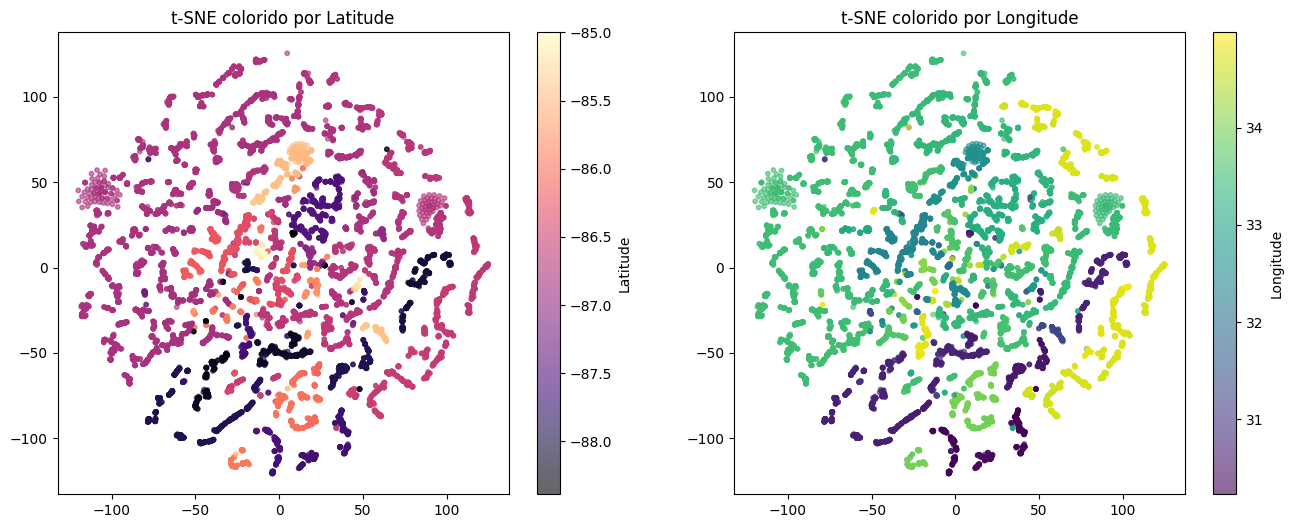

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

n_samples = 15000
indices = np.random.choice(len(loc_embeds), n_samples, replace=False)

subset_embeds = loc_embeds[indices]
subset_coords = coords[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds_2d = tsne.fit_transform(subset_embeds)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sc1 = ax[0].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 0], cmap='magma', s=10, alpha=0.6)
ax[0].set_title("t-SNE colorido por Latitude")
plt.colorbar(sc1, ax=ax[0], label='Latitude')

sc2 = ax[1].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 1], cmap='viridis', s=10, alpha=0.6)
ax[1].set_title("t-SNE colorido por Longitude")
plt.colorbar(sc2, ax=ax[1], label='Longitude')

plt.show()